In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
palette = 'mako'

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, max_error, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras import models, layers

In [98]:
df = pd.read_pickle('../datasets/processed.pkl')
df.head(1)

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,segundos_depois_meia_noite,estado_semana,dia_semana,tipo_carga
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Dia da Semana,Segunda-feira,Carga leve


In [99]:
features = df.drop(columns = ['consumo_energia', 'data', 'segundos_depois_meia_noite', 'potencia_principal'])
target = df.consumo_energia

In [100]:
categorical = list(features.select_dtypes(include='category').columns)
numerical = list(features.select_dtypes(include='number').columns)

for col in categorical:
    features[col] = LabelEncoder().fit_transform(features[col])

In [101]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=777)

In [109]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        # ('cat', cat_transformer, categorical)
    ]
)

In [110]:
def create_model(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("model", model)]
    )

In [114]:
def create_scores(model_list, train_x, train_y, test_x, test_y):
    scores = {
        "Algorithm": [],
        "Type": [],
        "R2": [],
        "Max Error": [],
        "Mean Absolute Error": [],
        "Mean Squared Error": []
    }
    
    for algorithm, model_ in model_list.items():
        for item in ['Train', 'Test']:
            model = model_
            model.fit(train_x, train_y)
            
            if item == 'Train':
                pred_y = model.predict(train_x)
                scores['Type'].append('Train')
                target = train_y
            else:
                pred_y = model.predict(test_x)
                scores['Type'].append('Test')
                target = test_y
                
            scores['Algorithm'].append(algorithm)
            scores['R2'].append( round( r2_score(target, pred_y), 2) )
            scores['Max Error'].append( round( max_error(target, pred_y), 2) )
            scores['Mean Absolute Error'].append( round( mae(target, pred_y), 2) )
            scores['Mean Squared Error'].append( round( mse(target, pred_y) * 100, 2) )

    return pd.DataFrame(scores)

In [112]:
def create_plot(results: pd.DataFrame, n_rows: int, n_cols: int, rot=45):
    fig = plt.figure(figsize=(16, 10))
    for i, title in enumerate(results.columns[2:]):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.barplot(data=results, x='Algorithm', y=title, hue='Type', palette=palette, ax=ax)
        for value in ax.containers:
            ax.bar_label(value)
        ax.tick_params(axis='x', labelrotation=rot, size=12)
        ax.tick_params(axis='y', size=12)
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
        ax.grid(visible=True, color='black', linewidth=.25)
    fig.tight_layout()

In [115]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(random_state=777),
    'KNeighbors Regressor': create_model(KNeighborsRegressor()),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=777),
    'Linear Regression': LinearRegression()
}
scores = create_scores(model_list, x_train, y_train, x_test, y_test)
scores

,Algorithm,Type,R2,Max Error,Mean Absolute Error,Mean Squared Error
0,Random Forest Regressor,Train,1.00,16.37,0.20,25.97
1,Random Forest Regressor,Test,1.00,34.86,0.47,146.72
2,KNeighbors Regressor,Train,1.00,38.66,0.95,380.53
3,KNeighbors Regressor,Test,0.99,33.10,1.22,623.39
4,Decision Tree Regressor,Train,1.00,9.51,0.05,6.25
5,Decision Tree Regressor,Test,1.00,52.12,0.68,263.48
6,Linear Regression,Train,0.98,119.45,2.61,2184.12
7,Linear Regression,Test,0.98,121.83,2.66,2315.69


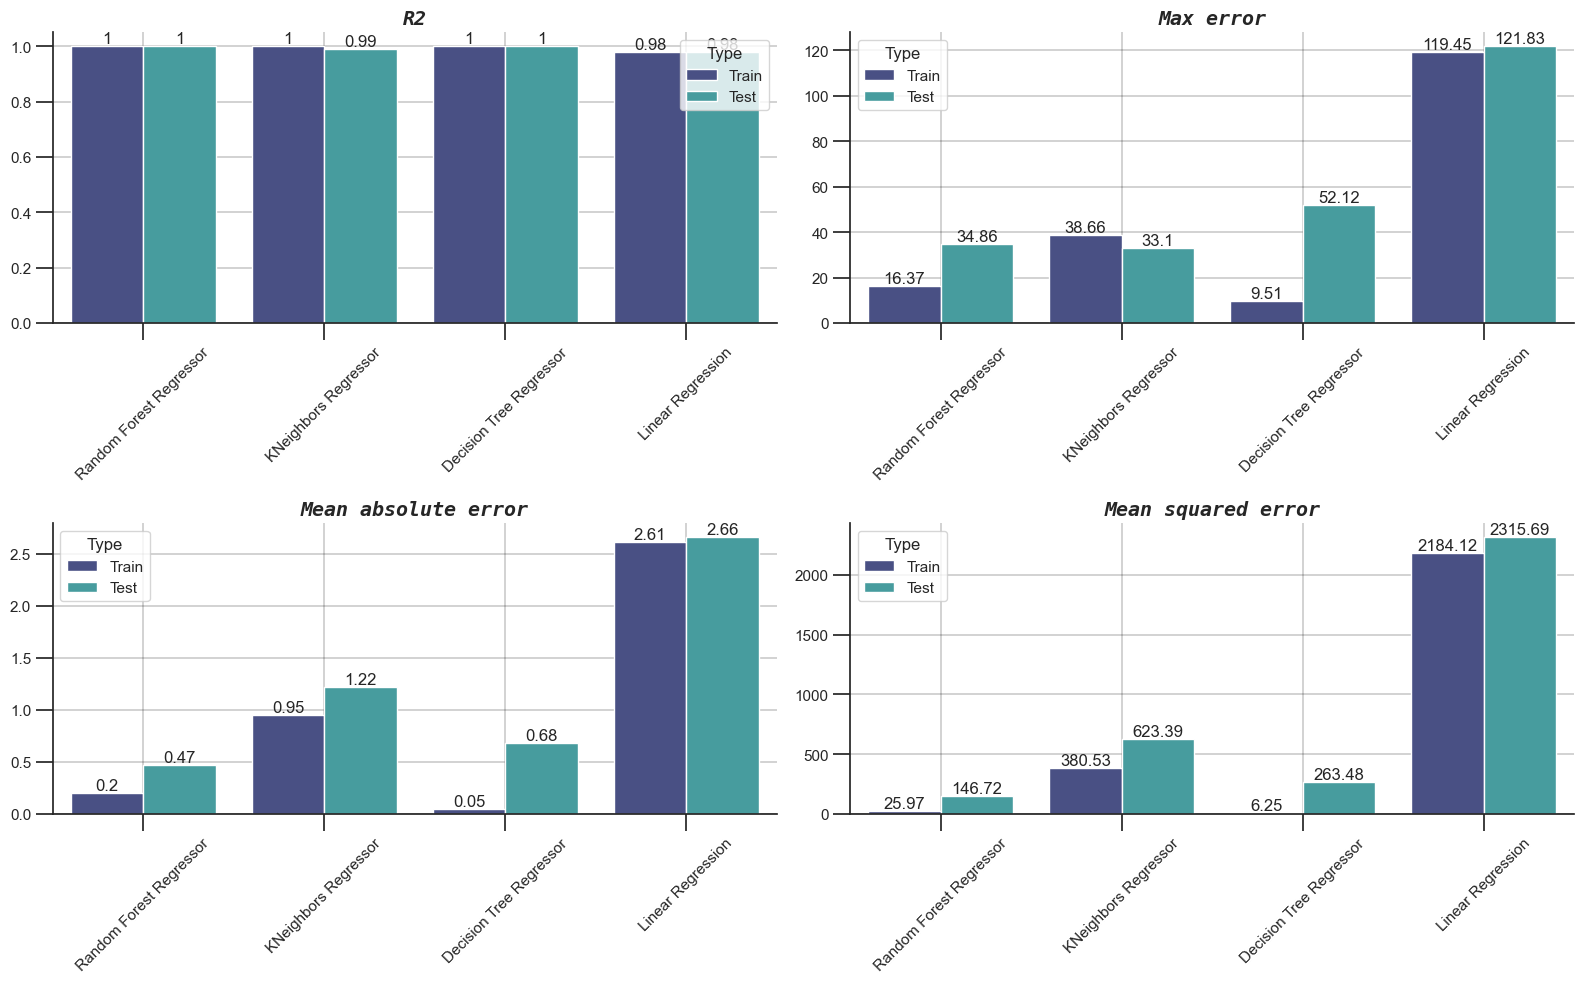

In [116]:
create_plot(scores, 2, 2)
plt.show()

In [117]:
df_corr = df.drop(columns = ['data', 'potencia_principal', 'segundos_depois_meia_noite']).copy()

label = LabelEncoder()
for col in df_corr.select_dtypes(exclude=[np.number]).columns:
    df_corr[col] = label.fit_transform(df_corr[col])

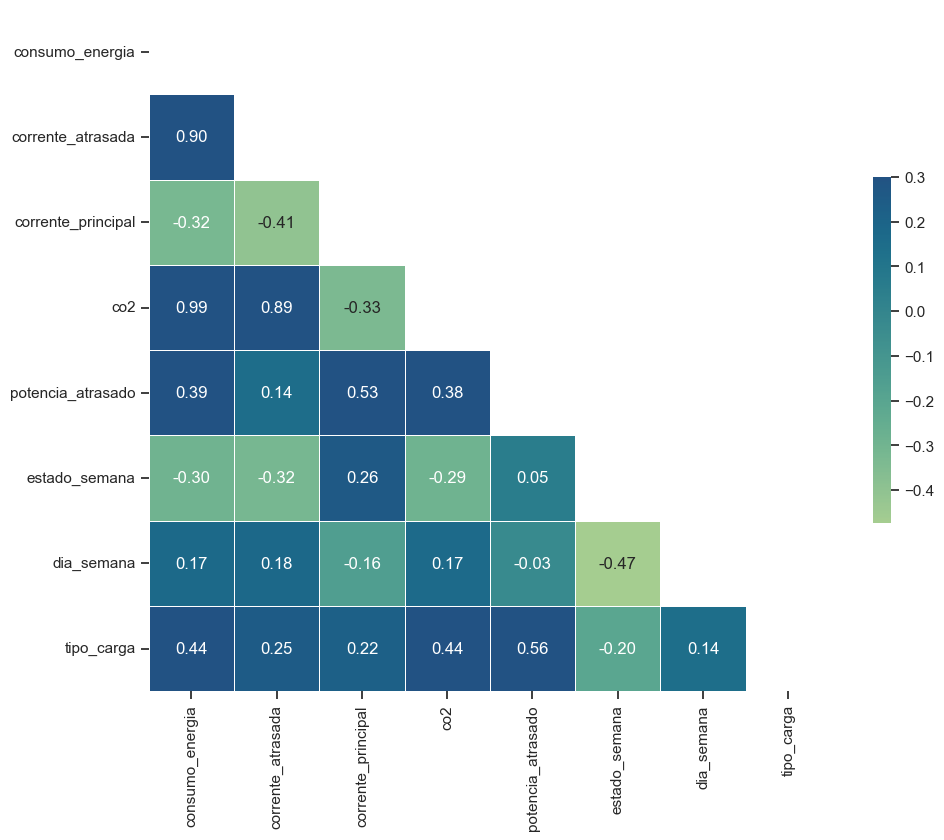

In [118]:
corr = df_corr.corr(method='pearson')

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap="crest", vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', ax=ax)

plt.show()

In [119]:
indices = corr.consumo_energia.abs().sort_values(ascending=False)[1:].index

In [ ]:
features = df.drop(columns = ['consumo_energia', 'data', 'potencia_principal', 'segundos_depois_meia_noite'])
target = df.consumo_energia

label = LabelEncoder()
for col in features.select_dtypes(exclude=[np.number]).columns:
    features[col] = label.fit_transform(features[col])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=777)

scaler = StandardScaler()

train_x_scaled = scaler.fit_transform(x_train)
test_x_scaled = scaler.transform(x_test)

# y_train, y_test = y_train / 100, y_test / 100

In [ ]:
def create_network():
    network = models.Sequential()
    network.add(layers.Dense(30, input_shape=(7, ), activation='relu'))
    network.add(layers.Dense(1))
    network.compile(loss="mae", optimizer='Adam', metrics=["mse"])
    return network

model = create_network()

history = model.fit(train_x_scaled, y_train, epochs=3, verbose=0, batch_size=10, 
                    validation_data=(test_x_scaled, y_test), shuffle=True)
pred_y = model.predict(test_x_scaled)

print(f'Algorithm: MLP')
print(f'R2 score: {r2_score(y_test, pred_y):.2f}',)
print(f'Mean Absolute Error: {mae(y_test, pred_y):.2f}')
print(f'Mean Absolute Percentage Error: {round(mape(y_test, pred_y) * 100, 2)}%')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

loss = pd.DataFrame({'training_loss': history.history["loss"], 'test_loss': history.history["val_loss"]})

epoch_count = np.arange(loss.shape[0])

sns.lineplot(data=loss, x=epoch_count, y='training_loss', label='Training', marker= '.', markersize=10, ax=ax)
sns.lineplot(data=loss, x=epoch_count, y='test_loss', label='Test', marker= '.', markersize=10, ax=ax)
ax.legend()
ax.set(xlabel='Epoch', ylabel='Loss')
ax.grid(visible=True, color='black', linewidth=.35)
plt.show()